In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pickle
import pyprind
import re
from PIL import Image
from IPython.core.display import Image as img
import numpy as np
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, ImageColorGenerator
import math

In [2]:
PATH_DATA = "V:/Programmazione/Amazon/"

In [3]:
df = pd.read_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

## Most Common words for each category and generally

In [4]:
"""
Given a the list of reviews the function return a list which contain all the words of the reviews which:
1. are not stopwords
2. contain only letters
"""
def deleteStopwords(listReviews):
    stopWords = set(stopwords.words('english')).union([u'br'])
    res = list()
    for s in pyprind.prog_bar(listReviews):
        text = nltk.word_tokenize(s)
        for t in text:
            t = t.lower()
            if not bool(re.search(r"[^A-Za-z]", t)) and t not in stopWords:
                res.append(t)
    return res

In [5]:
categories = df.product_category.unique().tolist()
print(categories)

[u'Music', u'Watches', u'Digital_Video_Download', u'Toys', u'Digital_Ebook_Purchase', u'Books', u'Video DVD', u'Mobile_Apps', u'Wireless', u'Electronics', u'Home Improvement', u'Digital_Music_Purchase', u'PC', u'Video Games', u'Camera', u'Shoes', u'Home', u'Musical Instruments', u'Sports', u'Baby', u'Video', u'Health & Personal Care', u'Automotive', u'Home Entertainment', u'Personal_Care_Appliances', u'Software', u'Office Products', u'Lawn and Garden', u'Pet Products', u'Kitchen', u'Beauty', u'Luggage', u'Apparel']


Apply deleteStopwords for each category

In [28]:
try:
    with open('%scategories_reviews_deleteStopwords.pickle'%PATH_DATA, 'rb') as handle:
        categories_reviews = pickle.load(handle)
except:
    categories_reviews = dict()
    for c in categories:
        print("I'm working on %s" % c)
        categories_reviews[c] = deleteStopwords(df[df.product_category==c].review_body.tolist())
    with open('%scategories_reviews_deleteStopwords.pickle'%PATH_DATA, 'wb') as handle:
        pickle.dump(categories_reviews, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('%scategories_reviews_deleteStopwords.pickle'%PATH_DATA, 'wb') as handle:
    pickle.dump(categories_reviews, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
#Function to draw the wordcloud
def make_word_cloud(dictWords, mask_path=None, background_color = "white", max_words = 2000, title = "", mux = 1):
    if(max_words>len(dictWords)):
        max_words = len(dictWords)
    topK = sorted(dictWords.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:max_words]
    text =[] 
    for word, value in topK:
        text+=[word]*int(round(value*mux))
    text = " ".join(text)
    if(mask_path!=None):
        # read the mask image
        mask = np.array(Image.open(mask_path))
        wc = WordCloud(background_color = background_color, max_words = max_words,  mask = mask, stopwords = None, collocations = False, max_font_size = 120)
        
    else:
        wc = WordCloud(background_color = background_color, max_words = max_words, stopwords = None, collocations = False, max_font_size = 120)
    # generate word cloud
    wc.generate(text)
    if(mask_path!=None):
        wc.recolor(color_func=ImageColorGenerator(mask))
    # store to file
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.title(title, fontsize = 15)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()
    plt.show()

In [9]:
freq_dist_categories = dict()
for c in pyprind.prog_bar(categories):
    freq_dist_categories[c] = nltk.FreqDist(categories_reviews[c])

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:45


Draw wordclouds for each category.

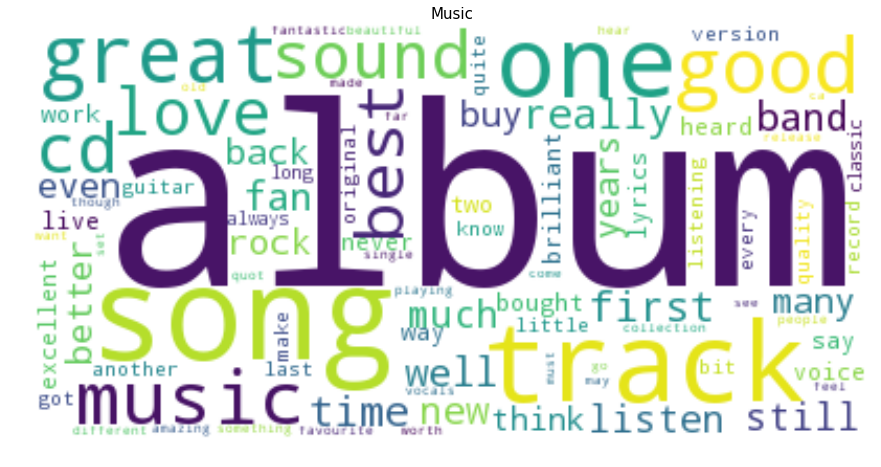

<Figure size 1080x720 with 0 Axes>

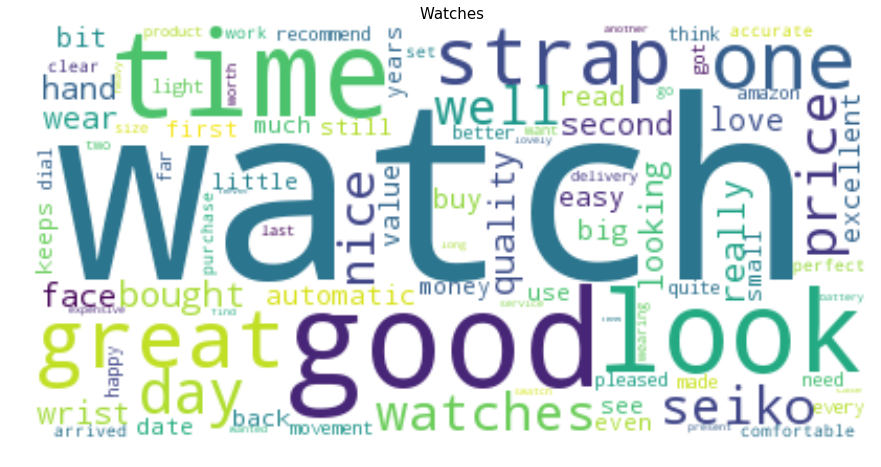

<Figure size 1080x720 with 0 Axes>

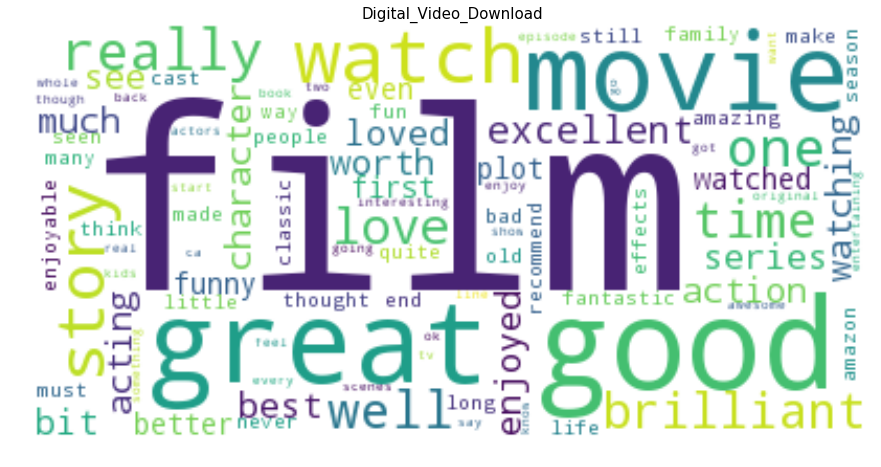

<Figure size 1080x720 with 0 Axes>

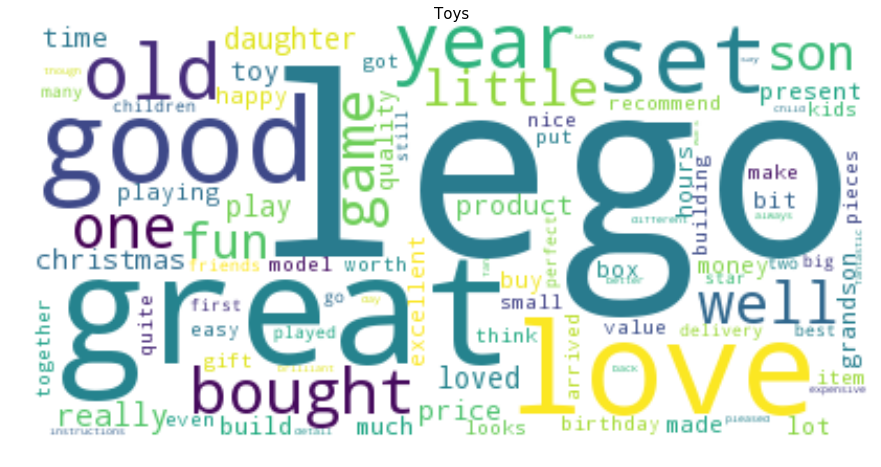

<Figure size 1080x720 with 0 Axes>

KeyboardInterrupt: 

In [29]:
n = 100
for c in categories:
    make_word_cloud({v:k for v,k in freq_dist_categories[c].most_common(n)}, max_words = n, title = c)

Union of the reviews of all the categories

In [11]:
all_reviews_without_stopwords = []
for c in categories:
    all_reviews_without_stopwords+=categories_reviews[c]

Draw wordlcloud taking into account all the categories

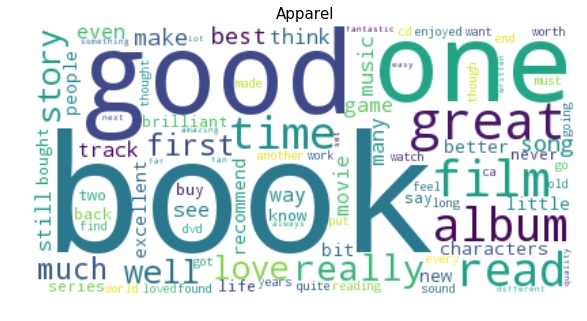

<Figure size 720x360 with 0 Axes>

In [12]:
freq = nltk.FreqDist(all_reviews_without_stopwords)
make_word_cloud({v:k for v,k in freq.most_common(100)}, max_words = n, title = c)

## Most important words based on the TF-IDF for each category

In [13]:
def tfIdf(fdistList):
    N_DOCUMENTS = len(fdistList)
    print("Total number of documents = %d" % N_DOCUMENTS)
    vocab = set()
    print("I'm creating the dictionary")
    for fdist in fdistList.values():
        vocab = vocab.union(set(fdist.keys()))#all words presents in all the documents
    idf = dict()
    print("I'm calculating the IDF")
    for word in vocab:
        count = 0.0
        for fdist in fdistList.values():
            if(word in fdist):
                count+=1
        idf[word] = math.log(N_DOCUMENTS/count)
    listTfIdf = dict()
    print("I'm calculating the tf-idf")
    i = 0
    for title, fdist in fdistList.items():
        listTfIdf[title] = dict()
        n_token_documen = float(sum(fdist.values()))
        for word in fdist:
            listTfIdf[title][word] = fdist[word] * idf[word] /  n_token_documen
        i+=1
    print("I have finished")
    return listTfIdf

In [14]:
listTfIdf = tfIdf(freq_dist_categories)

Total number of documents = 33
I'm creating the dictionary
I'm calculating the IDF
I'm calculating the tf-idf
I have finished


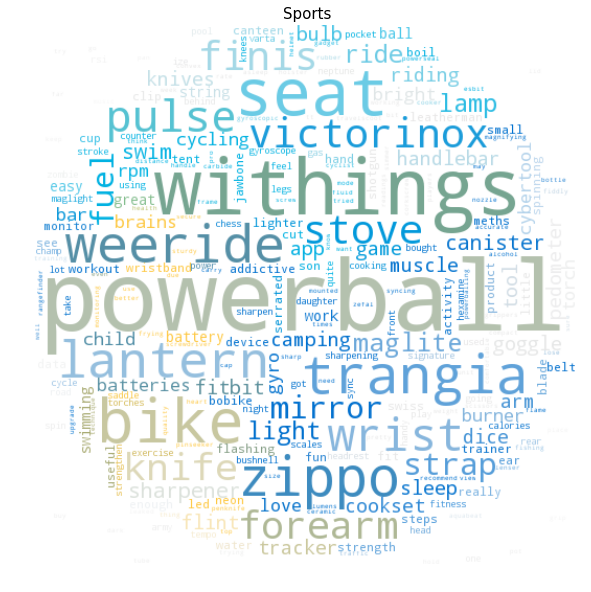

<Figure size 1080x720 with 0 Axes>

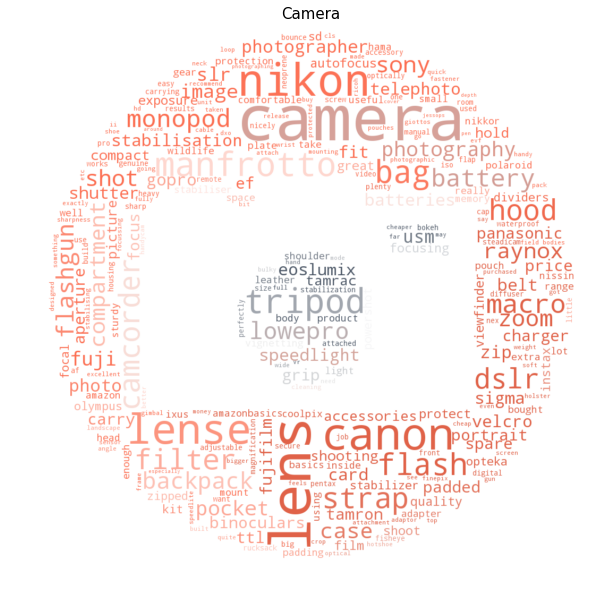

<Figure size 1080x720 with 0 Axes>

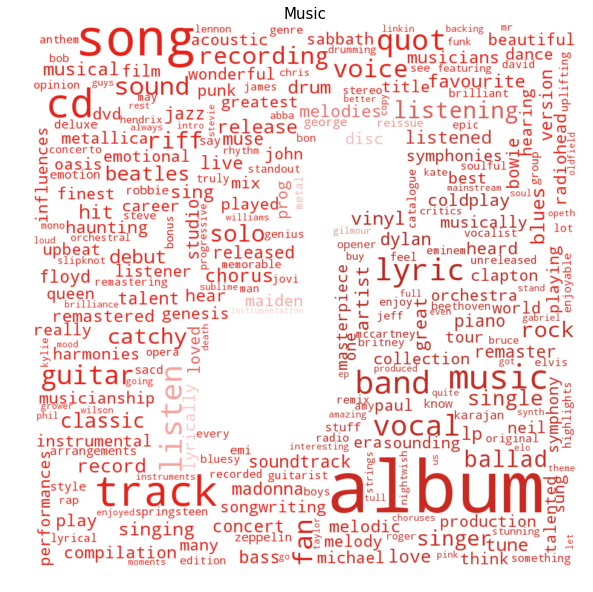

<Figure size 1080x720 with 0 Axes>

Pet Products


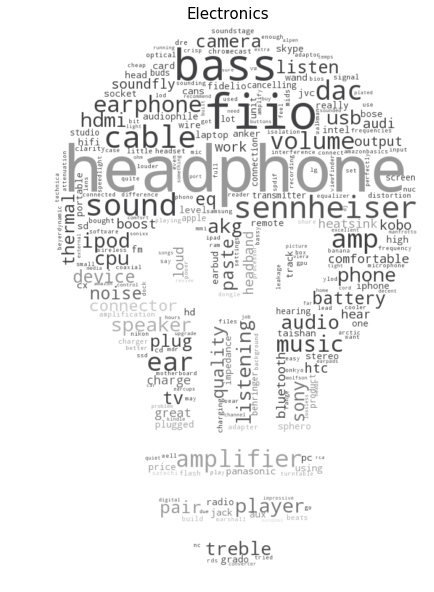

<Figure size 1080x720 with 0 Axes>

Health & Personal Care
Home Improvement
Beauty
Automotive
Video Games
Wireless
PC
Baby


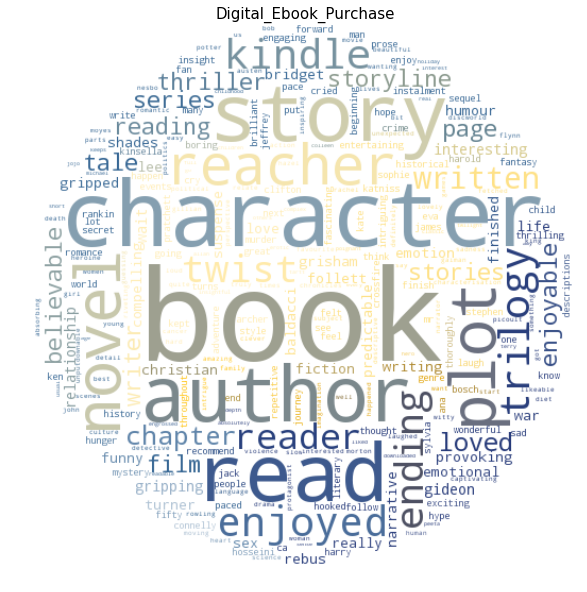

<Figure size 1080x720 with 0 Axes>

Personal_Care_Appliances
Kitchen


In [ ]:
mux = len(all_reviews_without_stopwords)
for category,tf_idf in listTfIdf.items():
    try:
        make_word_cloud(tf_idf, max_words = 300, title = category, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % category)
    except:
        print(category)